In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

### Simple linear regression using _Auto_ data set

In [2]:
Auto = load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [3]:
ms = MS(['horsepower'])
X = ms.fit_transform(Auto)
X.head()

,intercept,horsepower
name,,
chevrolet chevelle malibu,1.0,130
buick skylark 320,1.0,165
plymouth satellite,1.0,150
amc rebel sst,1.0,150
ford torino,1.0,140


In [4]:
y = Auto['mpg']
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [5]:
results.params

intercept     39.935861
horsepower    -0.157845
dtype: float64

In [6]:
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

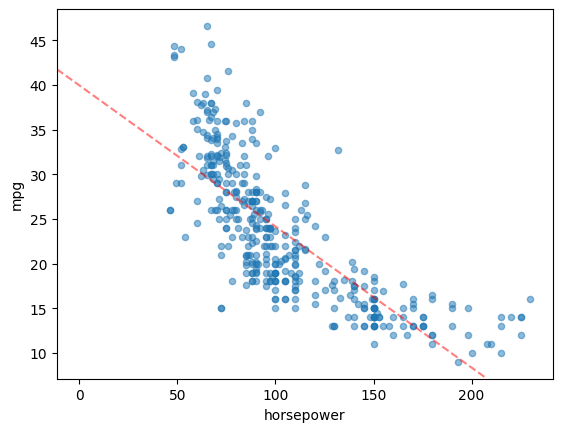

In [7]:
ax = Auto.plot.scatter('horsepower', 'mpg', alpha=.5)
ax.axline(
    (0, results.params.loc['intercept']), 
    slope=results.params.loc['horsepower'],
    color='r', linestyle='--', alpha=.5
);

In [8]:
results.conf_int(alpha=0.05)

,0,1
intercept,38.525212,41.346510
horsepower,-0.170517,-0.145172


Prediction and confidence intervals

In [9]:
Auto_test = pd.DataFrame({'horsepower': [98]})
X_test = ms.transform(Auto_test)
X_test

,intercept,horsepower
0,1.0,98


In [10]:
preds_test = results.get_prediction(X_test)
preds_test.predicted_mean

array([24.46707715])

In [11]:
preds_test.conf_int(alpha=0.02)

array([[23.88014154, 25.05401276]])

In [12]:
preds_test.conf_int(obs=True, alpha=0.02)

array([[12.99246647, 35.94168784]])

In [13]:
preds_test.summary_frame(alpha=0.02)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.467077,0.251262,23.880142,25.054013,12.992466,35.941688


In [14]:
preds_test.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.467077,0.251262,23.973079,24.961075,14.809396,34.124758


Residual plot

In [15]:
fitted, resid = results.fittedvalues, results.resid

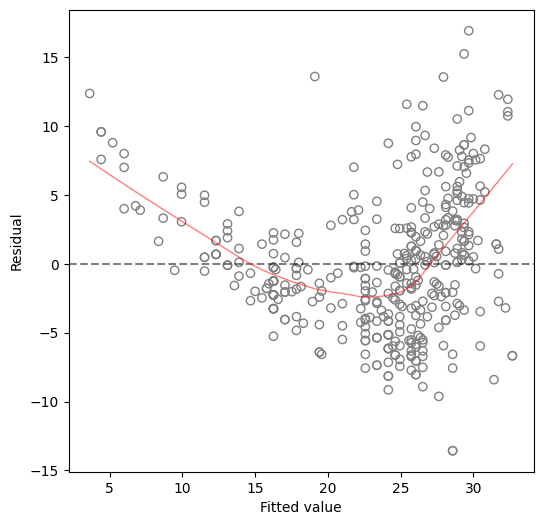

In [16]:
_, ax = subplots(figsize=(6, 6))
ax.scatter(
    fitted, 
    resid, 
    facecolors='none', 
    edgecolors='gray',
)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--', alpha=.5);

# lowess curve
lowess_smoothed = lowess(resid, fitted)
# split into x and y for plotting
x_lowess = lowess_smoothed[:, 0]
y_lowess = lowess_smoothed[:, 1]

ax.plot(
    x_lowess, 
    y_lowess,
    color='red', 
    linewidth=1,
    alpha=.5,
    label='LOWESS curve'
);

Leverage statistic

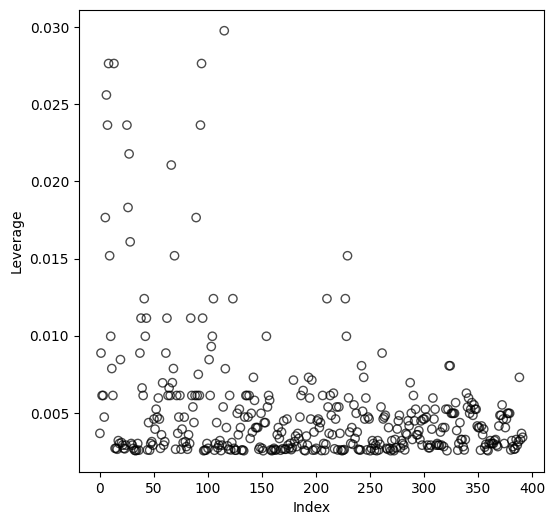

In [17]:
infl = results.get_influence()
_, ax = subplots(figsize=(6, 6))
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag, edgecolor='k', facecolor='none', alpha=0.7)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage');

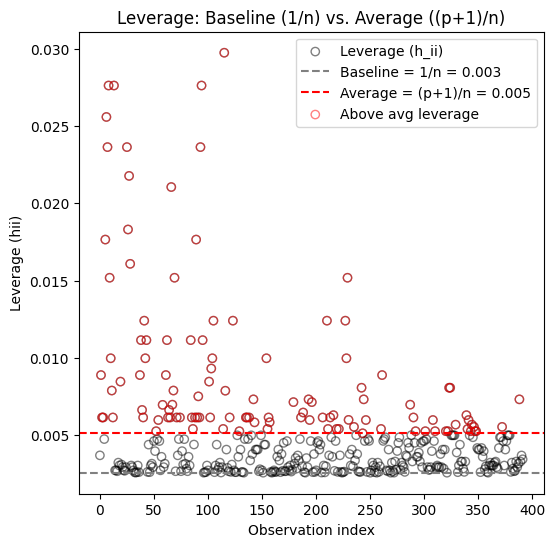

In [18]:
# 1. compute leverage values
leverage  = infl.hat_matrix_diag

# 2. sample size and number of parameters
n = X.shape[0]
p = X.shape[1]   # intercept and one predictor

# 3. thresholds
h_baseline = 1 / n      # minimal “equal” leverage
h_avg      = p / n      # average leverage = (p+1)/n

# 4. make the plot
fig, ax = subplots(figsize=(6,6))
ax.scatter(np.arange(n), leverage,
           facecolor='none', edgecolor='k', alpha=0.5,
           label='Leverage (h_ii)')

# 5. draw horizontal lines
ax.axhline(h_baseline, color='gray', linestyle='--',
           label=f'Baseline = 1/n = {h_baseline:.3f}')
ax.axhline(h_avg,      color='red',  linestyle='--',
           label=f'Average = (p+1)/n = {h_avg:.3f}')

# 6. highlight observations above average
high_idx = np.where(leverage > h_avg)[0]
ax.scatter(high_idx, leverage[high_idx],
           facecolor='none', edgecolor='red',
           alpha=0.5, label='Above avg leverage')

# 7. labels & legend
ax.set_xlabel('Observation index')
ax.set_ylabel('Leverage (hii)')
ax.set_title('Leverage: Baseline (1/n) vs. Average ((p+1)/n)')
ax.legend();

Studentized residual plot

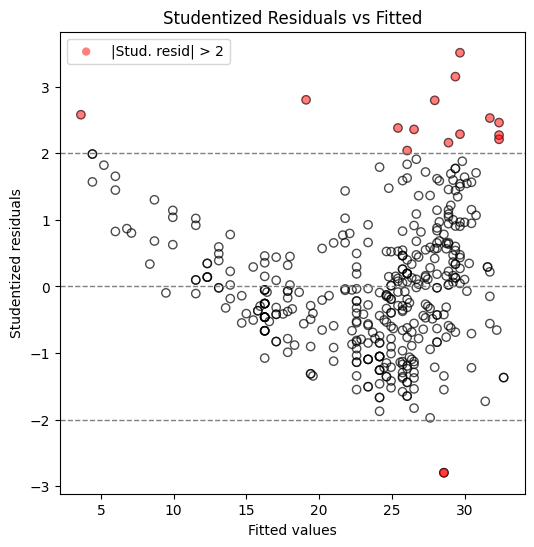

In [19]:
# 1. get influence measures
infl = results.get_influence()

# internal vs. external studentized residuals:
#  resid_int  = infl.resid_studentized_internal
#  resid_ext  = infl.resid_studentized_external
# use external if you want leave‐one‐out scaling:
resid_stud = infl.resid_studentized_external  

# 2. grab fitted values
fitted = results.fittedvalues

# 3. make the scatter plot
fig, ax = subplots(figsize=(6, 6))
ax.scatter(fitted, resid_stud, facecolor='none', edgecolor='k', alpha=0.7)

# 4. horizontal lines at 0, ±2, ±3
for thresh in [0, 2, -2]:
    ax.axhline(thresh, color='red' if abs(thresh)>2 else 'gray',
               linestyle='--', linewidth=1)

# 5. labels & title
ax.set_xlabel('Fitted values')
ax.set_ylabel('Studentized residuals')
ax.set_title('Studentized Residuals vs Fitted')

# 6. optional highlight of “large” studentized residuals
large = np.abs(resid_stud) > 2
ax.scatter(fitted[large], resid_stud[large],
           facecolor='red', edgecolor='none', alpha=0.5,
           label='|Stud. resid| > 2')

ax.legend();

### Multiple linear regression on _Auto_ data set

In [20]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


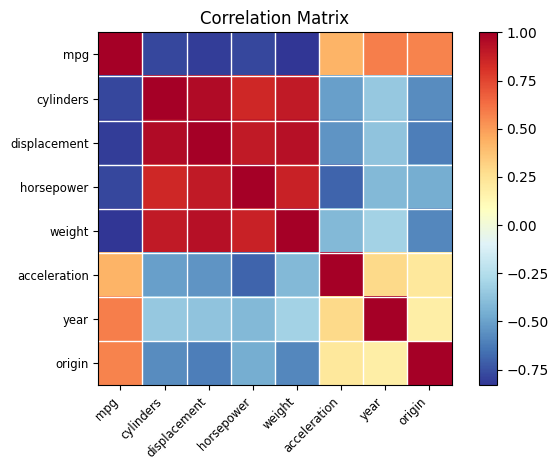

In [21]:
smg.plot_corr(Auto.corr().values, xnames=Auto.columns, ynames=Auto.columns);

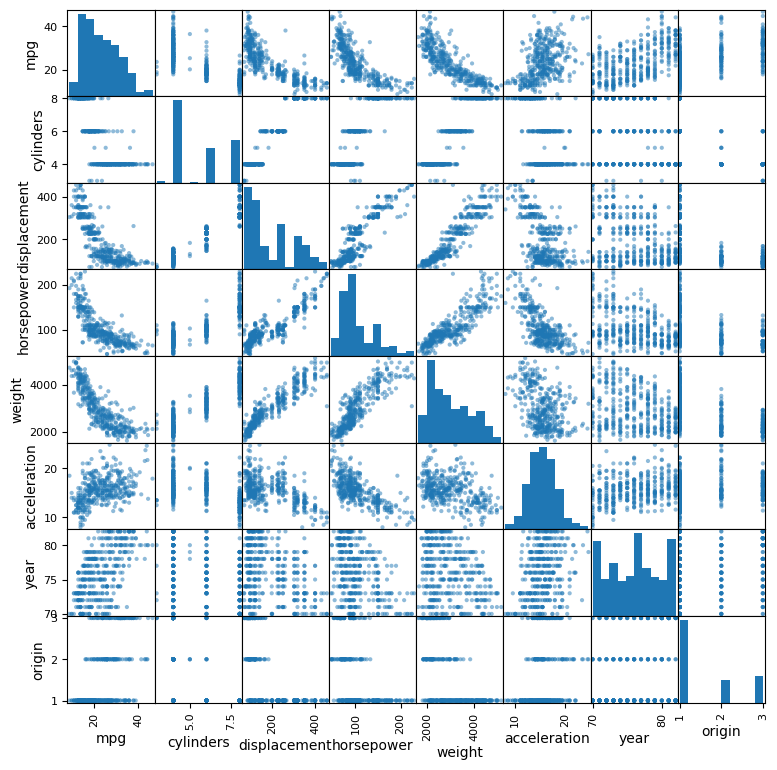

In [22]:
pd.plotting.scatter_matrix(Auto, figsize=(9,9));

Multiple linear regression

In [23]:
y = Auto['mpg']
y

name
chevrolet chevelle malibu    18.0
buick skylark 320            15.0
plymouth satellite           18.0
amc rebel sst                16.0
ford torino                  17.0
                             ... 
ford mustang gl              27.0
vw pickup                    44.0
dodge rampage                32.0
ford ranger                  28.0
chevy s-10                   31.0
Name: mpg, Length: 392, dtype: float64

In [24]:
predictors = Auto.columns.drop(['mpg'])
X = MS(predictors).fit_transform(Auto)
X

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,1.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,1.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,1.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,1.0,8,304.0,150,3433,12.0,70,1
ford torino,1.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,1.0,4,140.0,86,2790,15.6,82,1
vw pickup,1.0,4,97.0,52,2130,24.6,82,2
dodge rampage,1.0,4,135.0,84,2295,11.6,82,1


In [25]:
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,-17.2184,4.644,-3.707,0.000
cylinders,-0.4934,0.323,-1.526,0.128
displacement,0.0199,0.008,2.647,0.008
horsepower,-0.0170,0.014,-1.230,0.220
weight,-0.0065,0.001,-9.929,0.000
acceleration,0.0806,0.099,0.815,0.415
year,0.7508,0.051,14.729,0.000
origin,1.4261,0.278,5.127,0.000


Using `anova_lm` with `sm.OLS` is difficult, refer to [this link](https://github.com/statsmodels/statsmodels/issues/8241).

Below are the columns
- `df` - degrees of freedom
- `sum_sq`- sum of squares
- `mean_sq` - mean square
- `F` - F-statistic
- `PR(>F)` - p-value associated with F

In [26]:
formula = ' + '.join(predictors)
model_auto2 = smf.ols(f'mpg ~ {formula}', data=Auto).fit()
anova_lm(model_auto2)

,df,sum_sq,mean_sq,F,PR(>F)
cylinders,1.0,14403.083079,14403.083079,1300.683788,2.319511e-125
displacement,1.0,1073.344025,1073.344025,96.929329,1.530906e-20
horsepower,1.0,403.408069,403.408069,36.430140,3.731128e-09
weight,1.0,975.724953,975.724953,88.113748,5.544461e-19
acceleration,1.0,0.966071,0.966071,0.087242,7.678728e-01
year,1.0,2419.120249,2419.120249,218.460900,1.875281e-39
origin,1.0,291.134494,291.134494,26.291171,4.665681e-07
Residual,384.0,4252.212530,11.073470,NaN,NaN


Residual plots

In [27]:
results.model.exog_names

['intercept',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin']

In [28]:
results.model.exog_names

['intercept',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin']

In [29]:
results.model.exog

array([[  1. ,   8. , 307. , ...,  12. ,  70. ,   1. ],
       [  1. ,   8. , 350. , ...,  11.5,  70. ,   1. ],
       [  1. ,   8. , 318. , ...,  11. ,  70. ,   1. ],
       ...,
       [  1. ,   4. , 135. , ...,  11.6,  82. ,   1. ],
       [  1. ,   4. , 120. , ...,  18.6,  82. ,   1. ],
       [  1. ,   4. , 119. , ...,  19.4,  82. ,   1. ]])

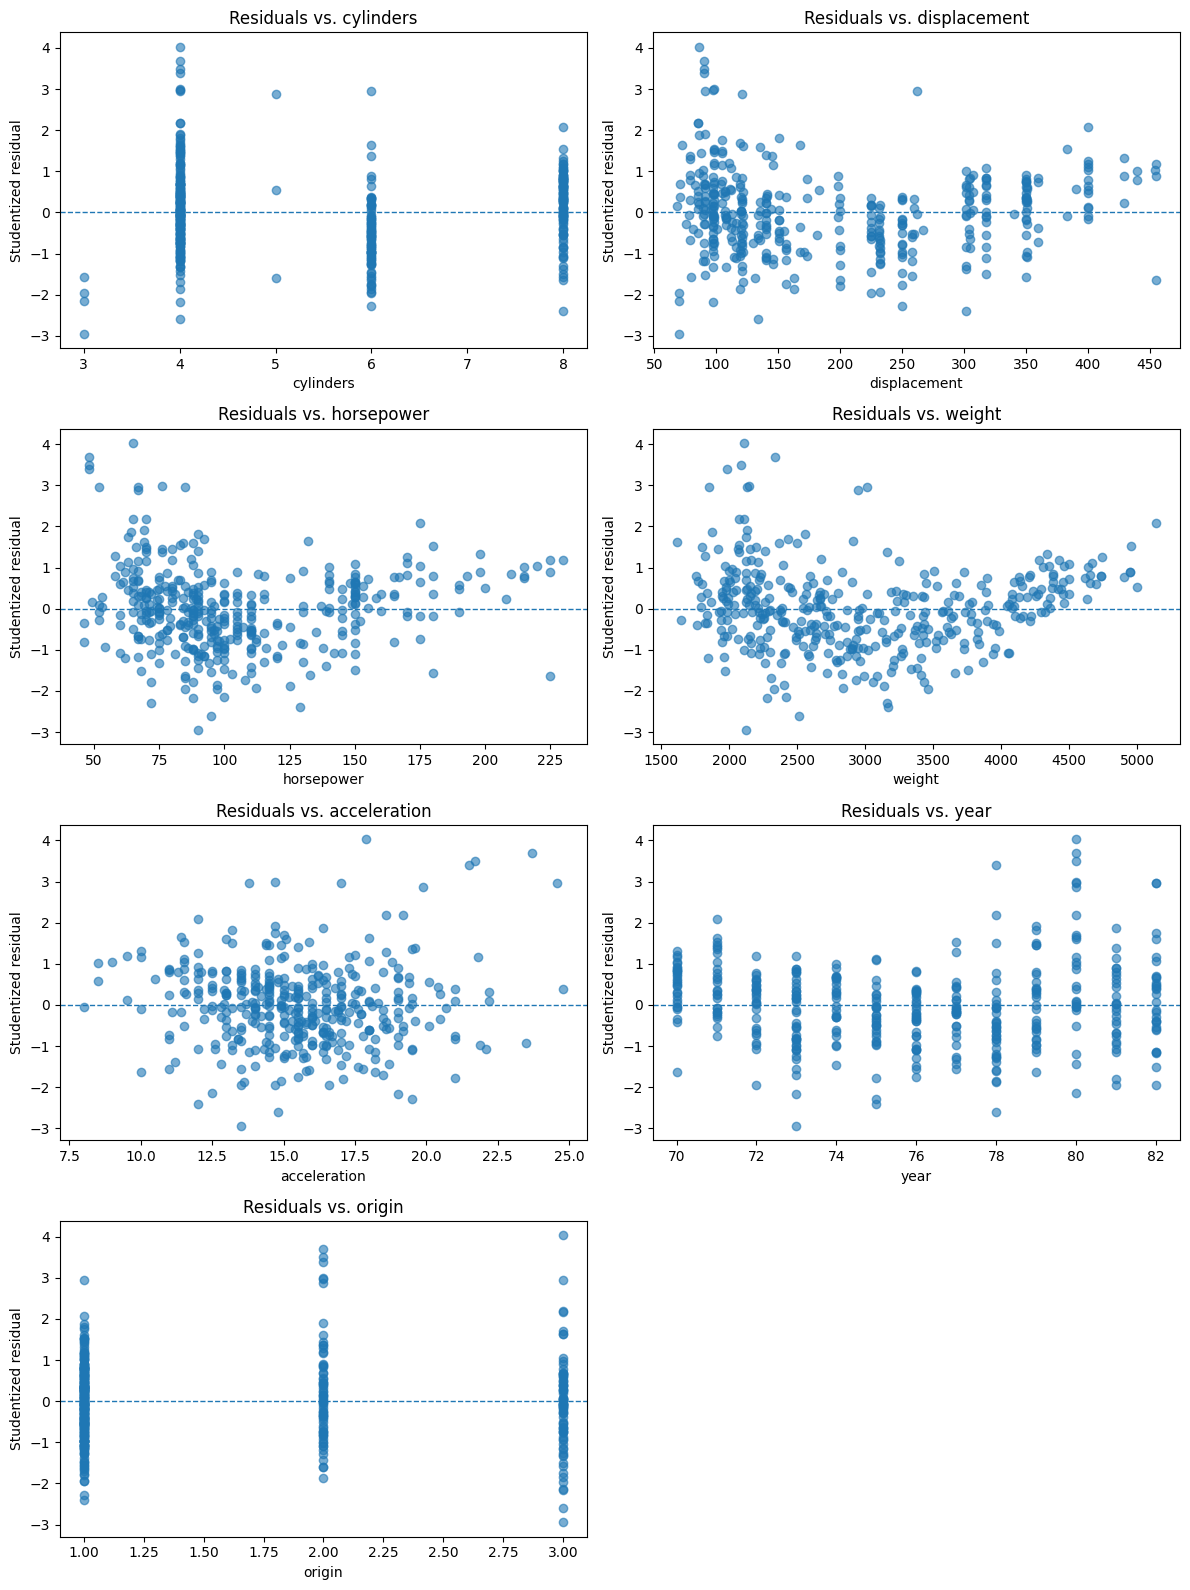

In [30]:
resid_stud = results.get_influence().resid_studentized_external

# get names and matrix of exogs
exog_names = results.model.exog_names  # e.g. ['intercept', 'x1', 'x2', ...]
exog  = results.model.exog        # shape (n_obs, n_vars+1)

# determine layout`
# skip the intercept (const) at index 0
plot_names = exog_names[1:]
n = len(plot_names)
ncols = 2
nrows = (n + 1)//ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))
axes = axes.flatten()

for i, ax in enumerate(axes[:n]):
    # column i+1 skips intercept
    xi = exog[:, i+1]
    ax.scatter(xi, resid_stud, alpha=0.6)
    # vertical line at 0
    ax.axhline(0, linestyle='--', linewidth=1)
    # x-name
    ax.set_xlabel(plot_names[i])
    ax.set_ylabel('Studentized residual')
    ax.set_title(f'Residuals vs. {plot_names[i]}')

# hide any extra subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()

Influence plot

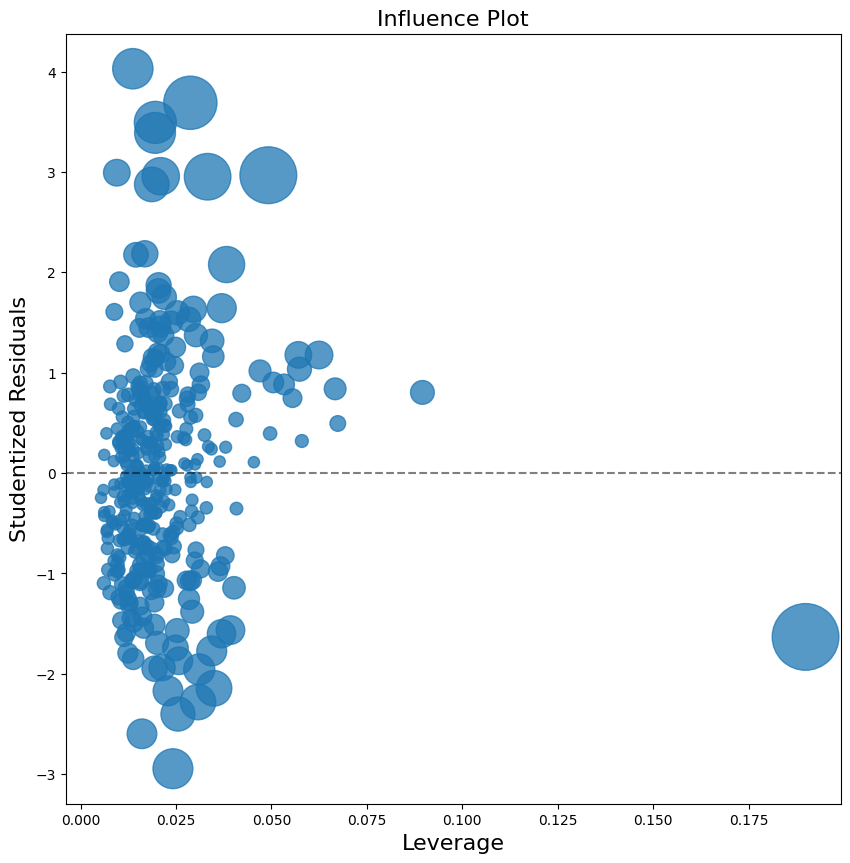

In [31]:
_, ax = plt.subplots(figsize=(10, 10))
smg.influence_plot(results, ax=ax)
ax.axhline(0, c='k', linestyle='--', alpha=.5)
# remove all labels
for txt in ax.texts:
    txt.set_visible(False)


Interaction terms

In [32]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [33]:
Auto['cylinders'].unique()

array([8, 4, 6, 3, 5])

In [34]:
Auto['origin'].unique()

array([1, 3, 2])

In [35]:
Auto['year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

In [36]:
list(predictors)

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin']

In [37]:
predictors = list(Auto.columns.drop(['mpg']))
interactions = [
    ('horsepower', 'displacement'),
    ('horsepower', 'weight')
]
X = MS(predictors + interactions).fit_transform(Auto)
X.head()

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin,horsepower:displacement,horsepower:weight
name,,,,,,,,,,
chevrolet chevelle malibu,1.0,8,307.0,130,3504,12.0,70,1,39910.0,455520.0
buick skylark 320,1.0,8,350.0,165,3693,11.5,70,1,57750.0,609345.0
plymouth satellite,1.0,8,318.0,150,3436,11.0,70,1,47700.0,515400.0
amc rebel sst,1.0,8,304.0,150,3433,12.0,70,1,45600.0,514950.0
ford torino,1.0,8,302.0,140,3449,10.5,70,1,42280.0,482860.0


In [38]:
model2 = sm.OLS(y, X)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,1.363900,4.476000,0.305,0.761
cylinders,0.415200,0.314000,1.321,0.187
displacement,-0.044300,0.017000,-2.684,0.008
horsepower,-0.225600,0.023000,-9.646,0.000
weight,-0.006600,0.002000,-4.256,0.000
acceleration,-0.177000,0.091000,-1.941,0.053
year,0.751500,0.045000,16.818,0.000
origin,0.704600,0.251000,2.806,0.005
horsepower:displacement,0.000300,0.000096,3.327,0.001
horsepower:weight,0.000025,0.000010,2.453,0.015


In [39]:
predictors = list(Auto.columns.drop(['mpg']))
interactions = [
    ('horsepower', 'displacement'),
    ('horsepower', 'weight'),
]
X = MS(predictors + interactions).fit_transform(Auto)
X.head()

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin,horsepower:displacement,horsepower:weight
name,,,,,,,,,,
chevrolet chevelle malibu,1.0,8,307.0,130,3504,12.0,70,1,39910.0,455520.0
buick skylark 320,1.0,8,350.0,165,3693,11.5,70,1,57750.0,609345.0
plymouth satellite,1.0,8,318.0,150,3436,11.0,70,1,47700.0,515400.0
amc rebel sst,1.0,8,304.0,150,3433,12.0,70,1,45600.0,514950.0
ford torino,1.0,8,302.0,140,3449,10.5,70,1,42280.0,482860.0


In [40]:
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,1.363900,4.476000,0.305,0.761
cylinders,0.415200,0.314000,1.321,0.187
displacement,-0.044300,0.017000,-2.684,0.008
horsepower,-0.225600,0.023000,-9.646,0.000
weight,-0.006600,0.002000,-4.256,0.000
acceleration,-0.177000,0.091000,-1.941,0.053
year,0.751500,0.045000,16.818,0.000
origin,0.704600,0.251000,2.806,0.005
horsepower:displacement,0.000300,0.000096,3.327,0.001
horsepower:weight,0.000025,0.000010,2.453,0.015


Only the interaction terms are significant.